## Feed Forward Neural Network in Fake Data


### Importing Libraries

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import drive 
from oauth2client.client import GoogleCredentials

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Loading dataset

In [3]:
#read a '.csv' file into data-frame
df = pd.read_csv('gdrive/My Drive/text_pre_processing.csv', sep=',')

df.sample(5)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Unnamed: 0.1,title,text,subject,date,label,caps_in_title,text_tokens,text_urls,clean_text,title_urls,twitter_handles,clean_title,clean_text_tokens,clean_title_tokens
31728,31728,31734,France ready to host international meeting on ...,PARIS (Reuters) - France is considering whethe...,worldnews,2017-11-18,true,2,"['PARIS', '(Reuters)', 'France', 'is', 'consid...",[],PARIS - france is considering whether to hos...,[],[],france ready to host international meeting on ...,"['PARIS', 'france', 'is', 'considering', 'whet...","['france', 'ready', 'to', 'host', 'internation..."
10241,10241,10242,Verified #FakeNews AP Attempts To Discredit Fo...,AP published an article today that attempts to...,politics,2017-08-02,fake,23,"['AP', 'published', 'an', 'article', 'today', ...",[],AP published an article today that attempts to...,[],[],verified #fakenews AP attempts to discredit fo...,"['AP', 'published', 'an', 'article', 'today', ...","['verified', 'fakenews', 'AP', 'attempts', 'to..."
36241,36241,36247,"Netanyahu congratulates Merkel, sees anti-Semi...",JERUSALEM (Reuters) - Israeli Prime Minister B...,worldnews,2017-09-26,True,3,"['JERUSALEM', '(Reuters)', 'Israeli', 'Prime',...",[],JERUSALEM - israeli prime minister benjamin ...,[],[],"netanyahu congratulates merkel, sees anti-semi...","['JERUSALEM', 'israeli', 'prime', 'minister', ...","['netanyahu', 'congratulates', 'merkel', 'sees..."
20038,20038,20044,Donald Trump Jr. adds Washington lawyer to leg...,WASHINGTON (Reuters) - The president’s oldest ...,politicsNews,2017-07-23,true,4,"['WASHINGTON', '(Reuters)', 'The', 'president'...",[],"WASHINGTON - the president’s oldest son, don...",[],[],donald trump jr. adds washington lawyer to leg...,"['WASHINGTON', 'the', 'president', 'oldest', '...","['donald', 'trump', 'jr.', 'adds', 'washington..."
27056,27056,27062,North Carolina lawmaker dismisses U.S. deadlin...,"WINSTON-SALEM, N.C. (Reuters) - Republican lea...",politicsNews,2016-05-05,true,4,"['WINSTON', 'SALEM', 'N', 'C', '(Reuters)', 'R...",[],"WINSTON-SALEM, N.C. - republican leaders in ...",[],[],north carolina lawmaker dismisses U.S. deadlin...,"['WINSTON-SALEM', 'N.C.', 'republican', 'leade...","['north', 'carolina', 'lawmaker', 'dismisses',..."


In [4]:
#drop the duplicated and unwanted columns
df = df.drop(['Unnamed: 0'], axis = 1)
df = df.drop(['Unnamed: 0.1'], axis = 1)
df.sample(5)

,title,text,subject,date,label,caps_in_title,text_tokens,text_urls,clean_text,title_urls,twitter_handles,clean_title,clean_text_tokens,clean_title_tokens
28864,"Police evacuate Bonn Christmas market, probe s...",BERLIN (Reuters) - Police brought in experts a...,worldnews,2017-12-23,true,3,"['BERLIN', '(Reuters)', 'Police', 'brought', '...",[],BERLIN - police brought in experts and an ex...,[],[],"police evacuate bonn christmas market, probe s...","['BERLIN', 'police', 'brought', 'in', 'experts...","['police', 'evacuate', 'bonn', 'christmas', 'm..."
30382,Support for anti-immigration Sweden Democrats ...,STOCKHOLM (Reuters) - Support for the far-righ...,worldnews,2017-12-05,true,3,"['STOCKHOLM', '(Reuters)', 'Support', 'for', '...",[],"STOCKHOLM - support for the far-right, anti-...",[],[],support for anti-immigration sweden democrats ...,"['STOCKHOLM', 'support', 'for', 'the', 'far-ri...","['support', 'for', 'anti-immigration', 'sweden..."
30334,White House confirms Trump discussed Jerusalem...,WASHINGTON (Reuters) - President Donald Trump ...,worldnews,2017-12-05,true,5,"['WASHINGTON', '(Reuters)', 'President', 'Dona...",[],WASHINGTON - president donald trump spoke se...,[],[],white house confirms trump discussed jerusalem...,"['WASHINGTON', 'president', 'donald', 'trump',...","['white', 'house', 'confirms', 'trump', 'discu..."
5269,Trump SHREDS All Remaining Ideas That He’s No...,"Nobody can accuse King Cheeto, a.k.a. Donald T...",News,2016-07-29,fake,20,"['Nobody', 'can', 'accuse', 'King', 'Cheeto', ...",[],"nobody can accuse king cheeto, a.k.a. donald t...",[],[],trump SHREDS all remaining ideas that he’s not...,"['nobody', 'can', 'accuse', 'king', 'cheeto', ...","['trump', 'SHREDS', 'all', 'remaining', 'ideas..."
36281,Exclusive: Mexico unlikely to find more quake ...,MEXICO CITY (Reuters) - Mexico will search ano...,worldnews,2017-09-26,True,2,"['MEXICO', 'CITY', '(Reuters)', 'Mexico', 'wil...",[],MEXICO CITY - mexico will search another thr...,[],[],exclusive: mexico unlikely to find more quake ...,"['MEXICO', 'CITY', 'mexico', 'will', 'search',...","['exclusive', 'mexico', 'unlikely', 'to', 'fin..."


In [5]:
#show some basic description 
df.describe().T

,count,mean,std,min,25%,50%,75%,max
caps_in_title,38638.0,13.545059,14.541594,1.0,3.0,6.0,20.0,137.0


In [6]:
#and other extra info for this dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38638 entries, 0 to 38637
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   title               38638 non-null  object
 1   text                38638 non-null  object
 2   subject             38638 non-null  object
 3   date                38638 non-null  object
 4   label               38638 non-null  object
 5   caps_in_title       38638 non-null  int64 
 6   text_tokens         38638 non-null  object
 7   text_urls           38638 non-null  object
 8   clean_text          38638 non-null  object
 9   title_urls          38638 non-null  object
 10  twitter_handles     38638 non-null  object
 11  clean_title         38638 non-null  object
 12  clean_text_tokens   38638 non-null  object
 13  clean_title_tokens  38638 non-null  object
dtypes: int64(1), object(13)
memory usage: 4.1+ MB


### Splitting Dataset Procedure

---
We split the data in 3 smaller datasets:
* Training, validation and test datasets



In [7]:
#the column 'clean_text' is the one we want to split
X = df['clean_text'].reset_index(drop=True)

X.sample(10)

15893    CBO DIRECTOR: how long the nation could sustai...
22915    WASHINGTON   - congressional democrats on frid...
12960    dana loesch gives us the lowdown on what would...
18556    RICHMOND, va.   - speaking as a folksy physici...
29820    BERLIN   - german chancellor angela merkel s c...
4505     someone had to say it. okay, liberals have bee...
38500    ASTANA   - the international atomic energy age...
7636     after witnessing disgraceful debate after disg...
33583    ALMATY   - kazakhstan is to change its officia...
36355    BRUSSELS   - european commission president jea...
Name: clean_text, dtype: object

In [8]:
y = df['label'].to_frame()

y.sample(10)

,label
9482,fake
9692,fake
8389,fake
36303,True
16187,fake
21268,true
28507,true
22464,true
10384,fake
27668,true


In [9]:
y[y['label'] == True] = 'true'
y = y.squeeze() #convert the data-frame to array
y

0        fake
1        fake
2        fake
3        fake
4        fake
         ... 
38633    true
38634    true
38635    true
38636    true
38637    true
Name: label, Length: 38638, dtype: object

---
At first, we will split the main dataset into two parts:
* Train-Validation dataset and
* Test dataset (20% of the whole dataset)

After that, we will split the Train-Validation dataset into another two:
* Train dataset and
* Validation dataset (15% of the train-validation dataset)

This splitting has been done in stratified manner, meaning that the dataset has been split uniformly based on the percentage of 'fake' - 'true' news.

In [10]:
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import StratifiedShuffleSplit

In [11]:
#sss: stratified shuffle split
test_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.15, random_state=0)
test_sss

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.15,
            train_size=None)

In [12]:
val_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
val_sss

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None)

In [13]:
#split in train-validation dataset and test dataset
X_train_val, X_test, y_train_val, y_test = None, None, None, None

#get the indexes for each dataset
for train_index, test_index in test_sss.split(X, y):
    
    print("TRAIN-VAL:", train_index[:10], "TEST:", test_index[:10])
    
    X_train_val, X_test = X[train_index], X[test_index]
    y_train_val, y_test = y[train_index], y[test_index]

TRAIN-VAL: [ 1473 20236  7194  1230   616 12707 28037  4521 22830 29675] TEST: [19888  4253   662 36631 28200 29359  4560  5729 19468 11209]
TRAIN-VAL: [ 9024 26688 34918 18091 29506  8416   653  3435 16402 34528] TEST: [34604  9150  6520   314  4665  6165  6877 13644 17807 33967]
TRAIN-VAL: [34104 21838 10327 37277 23630  9920 22776 26922 22315 32809] TEST: [25977 34988 25811 36094  7844 24844 37242 15920 19439 18091]
TRAIN-VAL: [17460 25343 37380  2580 24307 12609 21504 23244 36770 35115] TEST: [13156 21501 37170 13348  7988 37994   726  5448 32161 36186]
TRAIN-VAL: [29590 30461 17874 26870 29052 34387 32935  5171 25197 21626] TEST: [26046   568 36477 16728 19908  3977 21815 17381 34919 19756]


In [14]:
X_train_val.head() #show the first 5 indexes

29590    MOSCOW   - president vladimir putin warned on ...
30461    NAIROBI   - a prominent strategist for kenya s...
17874    WASHINGTON   - the senate banking committee wi...
26870    WASHINGTON   - a small group of bipartisan sen...
29052    BRUSSELS   - the european union wants a transi...
Name: clean_text, dtype: object

In [15]:
#reset the indexes
X_train_val = X_train_val.reset_index(drop=True)
y_train_val = y_train_val.reset_index(drop=True)

In [16]:
#split the train-validation dataset into train and validation dataset
X_train, X_val, y_train, y_val = None, None, None, None

for train_index, val_index in val_sss.split(X_train_val, y_train_val):
    
    print("TRAIN:", train_index[:10], "VALID:", test_index[:10])
    
    X_train, X_val = X_train_val[train_index], X_train_val[val_index]
    y_train, y_val = y_train_val[train_index], y_train_val[val_index]

TRAIN: [21059 18090 10746  9059 14280  8867 21261  4574 30003 22296] VALID: [26046   568 36477 16728 19908  3977 21815 17381 34919 19756]
TRAIN: [20536 32342 10603 11014  8117  9314 20198 30989 32332 25280] VALID: [26046   568 36477 16728 19908  3977 21815 17381 34919 19756]
TRAIN: [17278  3304 17991 16413 17844  4611 25288 23908 21290  3519] VALID: [26046   568 36477 16728 19908  3977 21815 17381 34919 19756]
TRAIN: [31686  5123 12174  2936  4837  2756 12709 24970 28610 13783] VALID: [26046   568 36477 16728 19908  3977 21815 17381 34919 19756]
TRAIN: [30354 26074 17840 16060 27602  4549  4944  8783 25021  4942] VALID: [26046   568 36477 16728 19908  3977 21815 17381 34919 19756]


In [17]:
#see the final results
print('X_train_val shape: {}'.format(X_train_val.shape))
print('y_train_val shape: {}'.format(y_train_val.shape))
print()

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print()

print('X_val shape: {}'.format(X_val.shape))
print('y_val shape: {}'.format(y_val.shape))

print()
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train_val shape: (32842,)
y_train_val shape: (32842,)

X_train shape: (26273,)
y_train shape: (26273,)

X_val shape: (6569,)
y_val shape: (6569,)

X_test shape: (5796,)
y_test shape: (5796,)


### One - Hot Encoding 

In [18]:
#encoding the labels using a One-Hot Encoder
y_enc = OneHotEncoder(sparse=False)

In [19]:
#reshape the dataset in order to have two columns
y_train_enc = y_enc.fit_transform(y_train.values.reshape(-1, 1))
y_train_enc

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

In [20]:
#later we transform the rest of the data
y_val_enc = y_enc.transform(y_val.values.reshape(-1, 1))
y_test_enc = y_enc.transform(y_test.values.reshape(-1, 1))

In [21]:
#print their format
print('y_train shape: {}'.format(y_train_enc.shape))
print('y_val shape: {}'.format(y_val_enc.shape))
print('y_test shape: {}'.format(y_test_enc.shape))

y_train shape: (26273, 2)
y_val shape: (6569, 2)
y_test shape: (5796, 2)


In [22]:
#the final categories from the encoder
y_enc.categories_

[array(['fake', 'true'], dtype=object)]

## Handling Text


In [23]:
#import the appropriate libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
#getting the stopwords in English language
stop = stopwords.words('english')

#### Now, we will split the text into tokens, in order to count them and get the most frequent. In the most cases, these tokens are stopwords.

In [25]:
#total words we will use for vectorization 
max_words = 10000

In [26]:
#this vectorizer is created in order to show us how many times each word appear
counter_vectorizer = CountVectorizer(
    encoding='utf-8',
    strip_accents='unicode',
    lowercase=True,
    stop_words= stop,
    ngram_range=(1, 1), # unigrams
    max_features=max_words,
    binary=False) # binary output or full counts

counter_vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=10000, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [27]:
#this vectorizer is created in order to return 0 or 1, based on the appearence of each word
binary_vectorizer = CountVectorizer(
    encoding='utf-8',
    strip_accents='unicode',
    lowercase=True,
    stop_words= stop,
    ngram_range=(1, 1), 
    max_features=max_words,
    binary=True)

binary_vectorizer

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=10000, min_df=1,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

* We will now fit the CountVectorizer in the datasets.

In [28]:
X_train_enc = counter_vectorizer.fit_transform(X_train)
X_train_enc

<26273x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 3826287 stored elements in Compressed Sparse Row format>

In [29]:
#with the above CountVectorizer we transform the Validation and Test Sets
X_val_enc = counter_vectorizer.transform(X_val)
X_test_enc = counter_vectorizer.transform(X_test)

In [30]:
print('X_train encoded shape: {}'.format(X_train_enc.shape))
print('X_val encoded shape: {}'.format(X_val_enc.shape))
print('X_test encoded shape: {}'.format(X_test_enc.shape))

X_train encoded shape: (26273, 10000)
X_val encoded shape: (6569, 10000)
X_test encoded shape: (5796, 10000)


### Build and Fit the *Model*

In [31]:
#imports for the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
import pydot

In [32]:
#get the number of classes for the y labels ('fake' - 'true' categories)
nb_classes = len(y_enc.categories_[0])

print('Number of Classes: {} (true - fake)'.format(nb_classes))

#set how many Epochs will train our Feed Forward Network
nb_epoch = 30

#the 'batch_size' is a number that will be fed to the model when training
batch_size = 64 

#set the dropout rate meaning how many neurons will be shutdown each time
dropout_rate = 0.4

Number of Classes: 2 (true - fake)


#### Model Setup

In [33]:
print('Building model...', end='\n\n')

#initialize an empty sequential structure, meaning that each layer we add, its output will be added as input in the next layer 
model = Sequential()

#add a dense layer (multi layer perception - MLP)
model.add(Dense(512, input_shape=(max_words,)))

#use a relu activation on MLP's outputs
model.add(Activation('relu'))

#use a dropout layer with with 40% of inputs dropped
model.add(Dropout(dropout_rate))

#add a dense layer
model.add(Dense(512))

model.add(Activation('relu'))

model.add(Dropout(dropout_rate))

#add a dense layer (MLP) 
model.add(Dense(nb_classes))

#use a sigmoid activation on 2nd MLP's outputs
model.add(Activation('sigmoid'))

#print model layers' info
print(model.summary())

Building model...

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               5120512   
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2

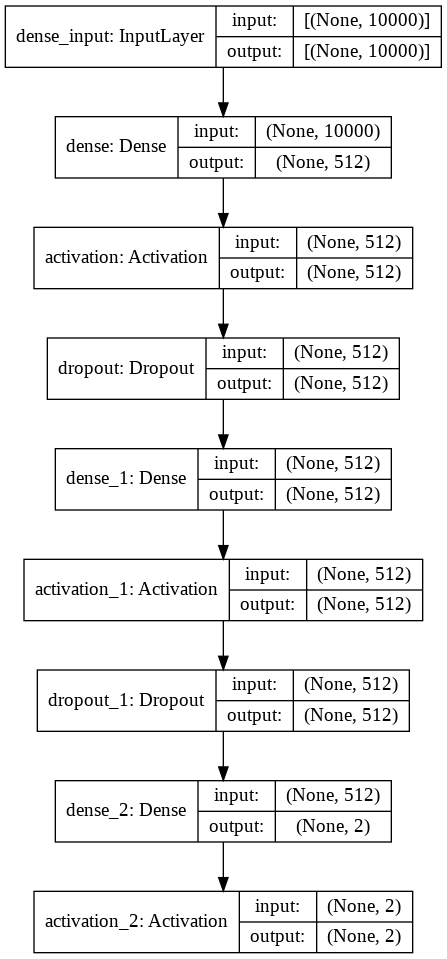

In [34]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### Compiling the model

In [35]:
#we use binary crossentropy as a loss function in the compiling of the model, because we want to predict whether the news are 'fake' or 'true'
#and 'Adam' as an optimizer (is more robust)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],)

### Training the Feed Forward Network Model

In [36]:
monitor = 'val_loss'

callbacks = [   
    #stop the training when a monitored quantity has stopped improving
    EarlyStopping(monitor=monitor, patience=7, verbose=1, restore_best_weights=True),
             
    #Reduce learning rate is called when a metric has stopped improving
    ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=5, verbose=1)]

In [37]:
#we fit the data to our model
history = model.fit(
    x=X_train_enc.todense(), #features (as dense inputs)
    y=y_train_enc,           #labels
    batch_size=batch_size,   
    epochs=nb_epoch,         
    verbose=2,
    callbacks = callbacks,             
    validation_data=(       
    X_val_enc.todense(),               
    y_val_enc))

Epoch 1/30
411/411 - 4s - loss: 0.1056 - accuracy: 0.9703 - val_loss: 0.0605 - val_accuracy: 0.9825
Epoch 2/30
411/411 - 3s - loss: 0.0246 - accuracy: 0.9941 - val_loss: 0.0602 - val_accuracy: 0.9842
Epoch 3/30
411/411 - 2s - loss: 0.0096 - accuracy: 0.9977 - val_loss: 0.0860 - val_accuracy: 0.9831
Epoch 4/30
411/411 - 2s - loss: 0.0084 - accuracy: 0.9980 - val_loss: 0.1619 - val_accuracy: 0.9782
Epoch 5/30
411/411 - 2s - loss: 0.0078 - accuracy: 0.9985 - val_loss: 0.1045 - val_accuracy: 0.9849
Epoch 6/30
411/411 - 2s - loss: 0.0200 - accuracy: 0.9978 - val_loss: 0.0901 - val_accuracy: 0.9830
Epoch 7/30
411/411 - 2s - loss: 0.0123 - accuracy: 0.9978 - val_loss: 0.0961 - val_accuracy: 0.9839

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 8/30
411/411 - 2s - loss: 0.0072 - accuracy: 0.9992 - val_loss: 0.1005 - val_accuracy: 0.9849
Epoch 9/30
411/411 - 2s - loss: 0.0019 - accuracy: 0.9998 - val_loss: 0.1003 - val_accuracy: 0.9846
Restoring model we

In [38]:
def plot_keras_history(history):
    """    
    :param history: 
    :return: 
    """ 
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        if i == 2:
          break
        else:
          #getting the training values
          metric_train_values = history.history.get(metric, [])
          
          #getting the validation values
          metric_val_values = history.history.get("val_{}".format(metric), [])

          epochs = range(1, len(metric_train_values) + 1)
          
          #leaving extra spaces to allign with the validation text
          training_text = "   Training {}: {:.5f}".format(metric,
                                                          metric_train_values[-1])

          #metric
          plt.figure(i, figsize=(12, 6))
          plt.plot(epochs, metric_train_values, 'b', label=training_text)
          
          #if the validation metric exists, then plot that as well
          if metric_val_values:
              validation_text = "Validation {}: {:.5f}".format(metric,
                                                              metric_val_values[-1])

              plt.plot(epochs, metric_val_values, 'g', label=validation_text)
          
          #add title, xlabel, ylabel, and legend
          plt.title('Model Metric: {}'.format(metric))
          plt.xlabel('Epochs')
          plt.ylabel(metric.title())
          plt.legend()

    plt.show()

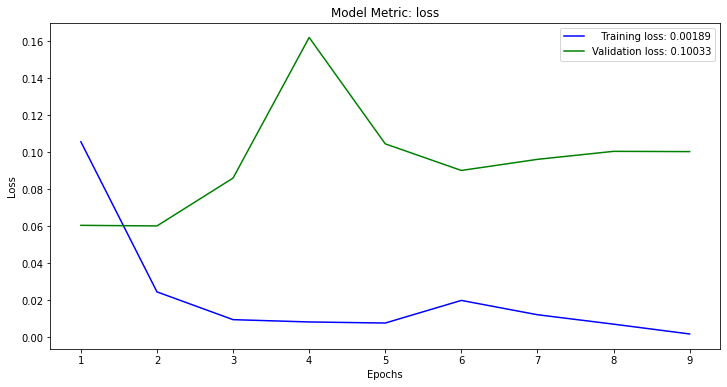

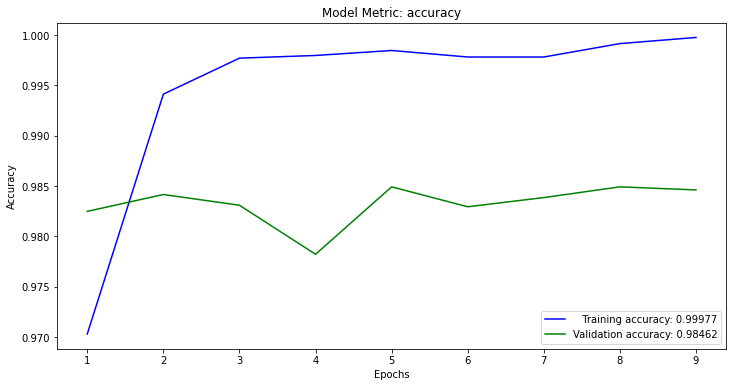

In [39]:
plot_keras_history(history)

### Model Evaluation

In [40]:
#evaluate and store on score variable the test dataset
score = model.evaluate(
    X_test_enc.todense(),    
    y_test_enc,             
    batch_size=batch_size,   
    verbose=2)

91/91 - 0s - loss: 0.0744 - accuracy: 0.9819


In [41]:
print('\nTest binary_crossentropy: {}'.format(score[0]))
print('\nTest accuracy: {:.3f} %'.format(score[1]*100))


Test binary_crossentropy: 0.07436400651931763

Test accuracy: 98.188 %


---
In the above plots and after the evaluation of the model, we can see the basic metrics of our Feed Forward Neural Network and how they evolve in the passing of the epochs. 
* First of all, the loss function, a function that shows the error, takes very small values. This is more than good, because it shows that the error for predicting the right class in our binary classification problem is minor. Combining with the fact of both the training and the validation loss have very low values (**less than 11%**) it is a good indicator of a very promising model. We have to clarify that the training loss indicates how well the model is fitting the training data, while the validation loss indicates how well the model fits new data.

* On the other hand, the accuracy metric, a metric  that depicts the ratio of number of correct predictions to the total number of input samples is really high (**more than 98%** for both training and validation accuracy). This means that our model is very accurate and predicts correctly the class of the news (fake or true) nearly all the time.

### Model Prediction 

In [42]:
#get the probabilities for each category for every news
y_test_pred_probs = model.predict(X_test_enc)
y_test_pred_probs

array([[9.79657829e-01, 2.71204989e-02],
       [1.00000000e+00, 5.42981802e-08],
       [8.75600323e-04, 9.99115884e-01],
       ...,
       [1.20660042e-08, 1.00000000e+00],
       [5.39057814e-02, 9.41702545e-01],
       [1.19655604e-04, 9.99888420e-01]], dtype=float32)

In [43]:
y_test_pred_probs.shape

(5796, 2)

In [44]:
#show the class they belong
y_test_preds = np.argmax(model.predict(X_test_enc), axis=-1)

y_test_preds[:50]

array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0])

In [45]:
#custom prediction function 
def get_one_hot_predictions(pred_probs):
    """
    """
    max_probs = np.max(pred_probs, axis=1)
    
    #reshaping to (len_of_predicts, 1)
    max_probs = max_probs.reshape(max_probs.shape[0], 1)

    return np.equal(pred_probs, max_probs).astype(float)

In [46]:
y_test_pred = get_one_hot_predictions(y_test_pred_probs)
y_test_pred

#check that each line has only one 1
y_test_pred.sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [47]:
#from the fitted One Hot Encoder we will get the inverse outcome (the category)
y_test_pred_news = y_enc.inverse_transform(y_test_pred).flatten()
y_test_pred_news[:20]

array(['fake', 'fake', 'true', 'fake', 'true', 'fake', 'true', 'fake',
       'true', 'true', 'true', 'fake', 'true', 'fake', 'fake', 'true',
       'fake', 'fake', 'true', 'true'], dtype=object)

* Some more evaluation merics.

In [48]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

In [49]:
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_test_pred_news)
pd.DataFrame(conf_mat, columns = y_enc.categories_, index=y_enc.categories_)

,fake,true
fake,2564,53
true,52,3127


* From the above confusion matrix we can observe that the performance of the model is pretty good. This is concluded by the fact that the predicted values do not differ a lot from the actual values. For example, from the 2627 false news, only the 53 predicted falsefully as true and from the 3179 true new only 52 predicted as fake.

In [50]:
print(classification_report(y_true=y_test, y_pred=y_test_pred_news))

              precision    recall  f1-score   support

        fake       0.98      0.98      0.98      2617
        true       0.98      0.98      0.98      3179

    accuracy                           0.98      5796
   macro avg       0.98      0.98      0.98      5796
weighted avg       0.98      0.98      0.98      5796



Before analyzing the classifiation report it is worth mentioning the definitions of the above metrics. 
* **Precision** : the number of correct positive results divided by the number of positive results predicted by the classifier.
* **Recall** : the number of correct positive results divided by the number of all samples that should have been identified as positive
* **F1 Score**: the Harmonic Mean between precision and recall. It shows how precise our classifier is (how many instances are classified correctly), as well as how robust it is (it does not miss a significant number of instances).
* **Support**: the number of news.

After checking the results of our classification report we can assume that our model performs really good.

In [51]:
def plot_binary_class_row_auc(y_true,
                              clf_names: list,
                              clfs_preds: list):
    """

    :param y_true: The true labels in one hot encoding
    :param clf_names: The names of the classifiers in order to plot
    :param clfs_preds: A list of numpy arrays, that contain predictions from various classifiers
    :return:
    """
    assert len(clf_names) == len(clfs_preds)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')

    for clf_name, preds in zip(clf_names, clfs_preds):
        fpr, tpr, thresholds = roc_curve(y_true,
                                         preds)

        # AUC value can also be calculated like this.

        auc_score = auc(fpr, tpr)

        plt.plot(fpr,
                 tpr,
                 label='{} (area = {:.3f})'.format(clf_name, auc_score))

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    # Zoom in view of the upper left corner.
    plt.figure(2)
    plt.xlim(0, 0.2)
    plt.ylim(0.7, 1)
    plt.plot([0, 1],
             [0, 1],
             'k--')

    for clf_name, preds in zip(clf_names, clfs_preds):
        fpr, tpr, thresholds = roc_curve(y_true,
                                         preds)

        # AUC value can also be calculated like this.

        auc_score = auc(fpr, tpr)

        plt.plot(fpr, tpr,
                 label='{} (area = {:.3f})'.format(clf_name, auc_score))

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve (zoomed in at top left)')
    plt.legend(loc='best')
    plt.show()

In [52]:
y_test = y_test.to_frame()
y_test[y_test['label'] == 'true'] = 1
y_test[y_test['label'] == 'fake'] = 0
y_test = y_test.squeeze()
y_test = np.asarray(y_test).astype('int64')
y_test

array([1, 0, 1, ..., 1, 1, 1])

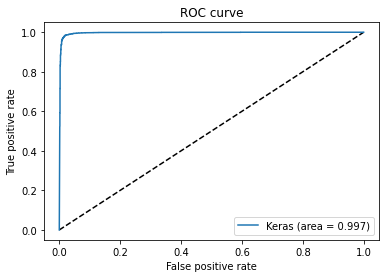

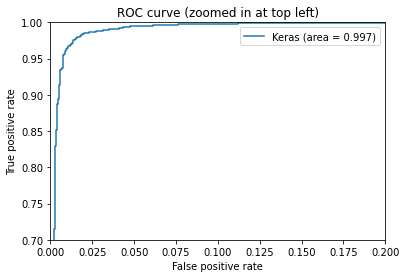

In [53]:
plot_binary_class_row_auc(y_true=y_test,
                          clf_names=['Keras'],
                          clfs_preds=[y_test_pred_probs[:,1].ravel()])

Area Under Curve (AUC) of a classifier is the probability that a classifier will rank a randomly chosen positive example higher than a randomly chosen negative example. So, we want the curve to approach as much the upper left corner of the graph as possible. In other words we want the ratio true positive to false positive to have the biggest possible value. This is happening to our case, something which indicates nearly perfect performance of our model (more than 99%).

* Let 's see an example for testing the accuracy of the model.

In [54]:
df[df['clean_text'] == X_val.iloc[2456,]]

,title,text,subject,date,label,caps_in_title,text_tokens,text_urls,clean_text,title_urls,twitter_handles,clean_title,clean_text_tokens,clean_title_tokens
16239,DETROIT COP UNDER FIRE FOR FACEBOOK POST: “The...,If this cop s comments were in lock-step with ...,left-news,2016-07-11,fake,43,"['If', 'this', 'cop', 's', 'comments', 'were',...",[],if this cop s comments were in lock-step with ...,[],[],DETROIT COP UNDER FIRE FOR FACEBOOK POST: “the...,"['if', 'this', 'cop', 'comments', 'were', 'in'...","['DETROIT', 'COP', 'UNDER', 'FIRE', 'FOR', 'FA..."


In [55]:
X_val.iloc[2456,]

'if this cop s comments were in lock-step with the leftist narrative, that it s okay to use violence to punish innocent cops as long as it brings attention to a few bad cops, would this even be a news story? why is this man, who is a target of the violent black lives matter movement, unable to speak out against the very people who seek to do him and his brothers/sisters harm?detroit police say they have launched an investigation into an officer s viral facebook rant about the black lives matter movement in reaction to the dallas police shooting.the post by officer nathan weekley has been viewed more than  ,  times, and reacts to the tragic dallas shooting that left five police officers killed and several others injured.the post reads: for the first time in my nearly   years as a law enforcement officer i contemplated calling into work in response to the outrageous act perpetrated against my brothers. it seems like the only response that will demonstrate our importance to society as a w

In [56]:
input_news = X_val.iloc[2456,]

#vectorizing news with Count Vectorizer
news_vect = counter_vectorizer.transform([input_news])

print(news_vect.shape, end='\n\n')

news_pred = model.predict(news_vect)

print('Probabilities:', end='\n\n')
print(news_pred, end='\n\n')

news_pred_hot = get_one_hot_predictions(news_pred)

print('Probabilities One Hot Vector:', end='\n\n')
print(news_pred_hot, end='\n\n')

print('News Prediction:', end='\n\n')
print(y_enc.inverse_transform(news_pred_hot)[0][0])

(1, 10000)

Probabilities:

[[9.999999e-01 9.313100e-08]]

Probabilities One Hot Vector:

[[1. 0.]]

News Prediction:

fake


## Embeddings

---
An embedding is a relatively low-dimensional space into which you can translate high-dimensional vectors. Embeddings are very useful for representing words, because the take into account the semantics of ecah word. For example, similar inputs are placed close together in the embedding space. 

The major difference with one-hot-encoding is that it turns text into sequence of numbers. 

In [57]:
import os
from glob import glob
from typing import Tuple, List

from tensorflow.python.keras.layers import Embedding, Flatten, Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tqdm import tqdm
from ipywidgets import interact

In [58]:
max_words = 15_000  #we will only take the 15K most used words in the whole news dataset

#initialize the Keras tokenizer
reviews_tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token='<OOV>')

reviews_tokenizer

In [59]:
texts = df['clean_text']

In [60]:
reviews_tokenizer.fit_on_texts(texts)  #create tokens by counting frequency

In [61]:
sequences = reviews_tokenizer.texts_to_sequences(texts) #create embedding (wonrds into sequence of numbers)

* These tokenizers create a dictionary that maps each word to a number. If we take a closer look, we can infer that those words are used more in the news take a lower token number. Some examples are the following:

In [62]:
word_index = reviews_tokenizer.word_index

print('Token for the word "news": {}'.format(word_index['news']))
print('Token for the word "the": {}'.format(word_index['the']))
print('Token for the word "happy": {}'.format(word_index['happy']))
print('Token for the word "sad": {}'.format(word_index['sad']))

Token for the word "news": 105
Token for the word "the": 2
Token for the word "happy": 1613
Token for the word "sad": 2378


* In order to continue, we have to make sure that all the sentences that will be used in our model will have the same length. So, we use the `Keras pad sequences tool`. This tool, cuts those sentences that are too big and for those that are too small adds zeros. 

Here, we make all the sentences to have length 100 words.

In [63]:
maxlen = 100

data = pad_sequences(sequences, maxlen=maxlen)

#So, we have 39K, 100 word sequences now
print('New data shape: {}'.format(data.shape))

New data shape: (38638, 100)


#### Data shuffling and splitting in train-validation

In [64]:
y = y.to_frame()
y[y['label'] == 'true'] = 1
y[y['label'] == 'fake'] = 0
y = y.squeeze()
y = np.asarray(y).astype('int64')
y

array([0, 0, 0, ..., 1, 1, 1])

In [65]:
#we turn all the data into training and validation datasets
labels = y # true - fake
labels

array([0, 0, 0, ..., 1, 1, 1])

* Shuffle the data. We first create indeces using the length of the text and later we shuffle them:

In [66]:
indices = np.arange(data.shape[0])  

#shuffling the indices on the fly
np.random.shuffle(indices)

data = data[indices]  #the shuffled texts
labels = labels[indices]  #the shuffled sentiments

In [67]:
training_samples = 30_000  #will be trained on 30K samples

#data splitting
x_train1 = data[:training_samples]
y_train1 = labels[:training_samples]

x_val1 = data[training_samples:]
y_val1 = labels[training_samples:]

#datasets format
print('X train shape: {}'.format(x_train1.shape))
print('y train shape: {}'.format(y_train1.shape))

print('X val shape: {}'.format(x_val1.shape))
print('y val shape: {}'.format(y_val1.shape))

X train shape: (30000, 100)
y train shape: (30000,)
X val shape: (8638, 100)
y val shape: (8638,)


In [68]:
# Setting the model
model1 = Sequential()
model1.add(Embedding(input_dim=max_words,
                      output_dim=50,
                      embeddings_initializer='uniform',
                      mask_zero=True,
                      input_length=maxlen))

model1.add(Flatten()) #flattening is converting the data into a 1-dimensional array for inputting it to the next layer

model1.add(Dense(32, activation='relu'))

model1.add(Dense(1, activation='sigmoid'))

print(model1.summary())

model1.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           750000    
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                160032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 910,065
Trainable params: 910,065
Non-trainable params: 0
_________________________________________________________________
None


In [69]:
history = model1.fit(x_train1, y_train1,
                     epochs=30,
                     batch_size=64,
                     callbacks = callbacks,
                     validation_data=(x_val1, y_val1))

Epoch 1/30
469/469 [==============================] - 4s 6ms/step - loss: 0.1086 - acc: 0.9587 - val_loss: 0.0485 - val_acc: 0.9826
Epoch 2/30
469/469 [==============================] - 3s 6ms/step - loss: 0.0064 - acc: 0.9986 - val_loss: 0.0530 - val_acc: 0.9823
Epoch 3/30
469/469 [==============================] - 3s 6ms/step - loss: 5.6257e-04 - acc: 1.0000 - val_loss: 0.0587 - val_acc: 0.9831
Epoch 4/30
469/469 [==============================] - 3s 6ms/step - loss: 1.8306e-04 - acc: 1.0000 - val_loss: 0.0588 - val_acc: 0.9834
Epoch 5/30
469/469 [==============================] - 3s 6ms/step - loss: 9.9947e-05 - acc: 1.0000 - val_loss: 0.0614 - val_acc: 0.9834
Epoch 6/30
469/469 [==============================] - 3s 6ms/step - loss: 6.2620e-05 - acc: 1.0000 - val_loss: 0.0636 - val_acc: 0.9834

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/30
469/469 [==============================] - 3s 6ms/step - loss: 4.6934e-05 - acc: 1.0000 - val_loss:

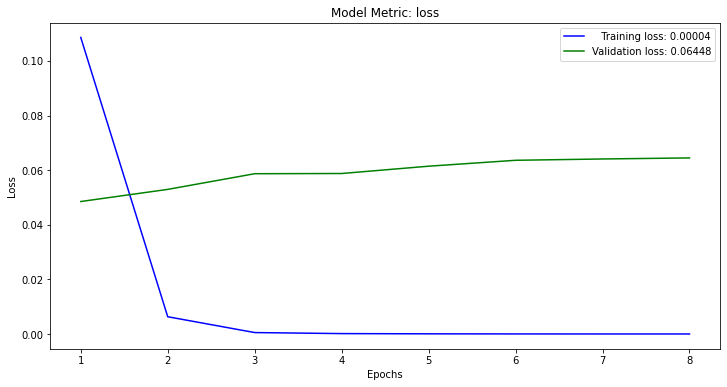

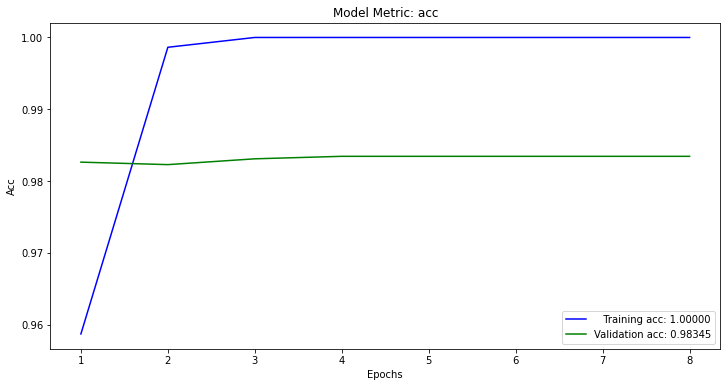

In [70]:
plot_keras_history(history)

* In this case we can observe that the model was created with embeddings are nearly perfect. We can see almost 0 loss and aproximately 1 accuracy.

### Predicting using the fitted model

Here is an example. We are giving a text in the model and it returns to us how much fake it is.

In [71]:
df.iloc[2199,]

title                  Muhammad Ali Jr. Detained AGAIN At Airport Ri...
text                  One day after he testified about being stopped...
subject                                                            News
date                                                         2017-03-11
label                                                              fake
caps_in_title                                                        17
text_tokens           ['One', 'day', 'after', 'he', 'testified', 'ab...
text_urls                                                            []
clean_text            one day after he testified about being stopped...
title_urls                                                           []
twitter_handles                                                      []
clean_title           muhammad ali jr. detained AGAIN at airport rig...
clean_text_tokens     ['one', 'day', 'after', 'he', 'testified', 'ab...
clean_title_tokens    ['muhammad', 'ali', 'jr.', 'detained', 'AG

In [72]:
# Demo on a positive text
my_text = df.iloc[2199,1]

seq = reviews_tokenizer.texts_to_sequences([my_text])
print('raw seq:', seq)

seq = pad_sequences(seq, maxlen=maxlen)
print('padded seq:', seq)

prediction = model1.predict(seq)
print('truthfulness:', prediction)

raw seq: [[53, 187, 52, 14, 3717, 40, 115, 1640, 21, 334, 163, 142, 66, 15, 9, 353, 489, 2, 810, 4, 13688, 8668, 6709, 2502, 18, 1644, 21, 334, 163, 302, 27, 99, 10, 5, 1283, 2117, 6709, 2502, 1416, 3659, 3, 104, 10, 192, 3, 3158, 40, 2, 103, 99, 14, 18, 1644, 10, 20, 169, 148, 26, 5, 258, 505, 241, 311, 14, 688, 17, 20, 1162, 7, 7806, 2502, 1416, 18, 2283, 1644, 28, 4725, 9383, 1753, 288, 1673, 10, 650, 1, 6, 1999, 11, 91, 793, 17, 163, 1, 75, 17, 426, 507, 685, 93, 29, 44, 5, 353, 6, 143, 113, 44, 133, 228, 578, 27, 99, 2, 10471, 9, 810, 408, 45, 111, 136, 16, 3, 608, 109, 2808, 3, 845, 5, 2117, 326, 7, 5, 104, 767, 1673, 2, 11034, 632, 265, 327, 17, 20, 5111, 63, 572, 2502, 623, 894, 1078, 98, 79, 1785, 28, 2067, 125, 1673, 7, 104, 10, 200, 11, 5, 2117, 3, 4725, 9383, 7162, 14, 688, 20, 2171, 5111, 2651, 3, 5, 1, 2161, 3, 133, 20, 9253, 849, 13, 20, 879, 1332, 1, 30, 18, 2983, 17, 75, 6, 5086, 2, 3294, 707, 632, 572, 2502, 18, 86, 8, 67, 18, 5, 642, 6, 8, 2, 2161, 706, 3, 324, 2, 19